In [1]:
# dev work for FGN conv layer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (4.0, 3.0)

In [4]:
import torch
import torch.nn as nn
import numpy as np

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

/home/felix/.local/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [5]:
in_channels = 1
out_channels = 2
kernel_size = 3
stride=1
padding=0
dilation=1
groups=1
bias=True
padding_mode='zeros'

In [6]:
# def get_output_shape(module: nn.Module, in_shape: tuple, device='cpu'):
#     # given a model and its in_feat shape
#     # compute the shape of the output
#     # only works for single output modules
#     # does no error checking or timeout, so use at your own risk
    
#     # generate random tensor of right shape
#     r = torch.rand(in_shape, device=device)
    
#     # pass the random tensor through the module
#     o = module(r)
    
#     # return shape as torch.size
#     return o.size()
    

In [7]:
# from  import get_output_shape

class FGN_Conv1d(nn.Module):
    # the fgn version of the convolutional 1d layer
    
    def __init__(self, in_features,
                 covar_type='diag', ordinal=2.0, first_layer=False,
                 **kwargs):
        super(FGN_Conv1d, self).__init__()
        # input dimension
        self.in_features = in_features
        # the associated conv1d layer
        self.Conv1d = nn.Conv1d(**kwargs)
        # output dimension
        self.out_features = 
    
        # covariance type for the gaussian: one of 'sphere', 'diag', 'full'
        self.covar_type = covar_type
        # ordinal used for the norm (distance to centers) computation 
        # (1=diamond, 2=euclidean, 3->float('inf')=approach manhattan)
        self.ordinal = ordinal
        # is this the first layer of the network? (ie: does it have only inputs or also gaussian input from previous layer?)
        self.first_layer = first_layer
        # centers of FGNs  
        self.centers = nn.Parameter(torch.Tensor(g_out_features, g_in_features), requires_grad=True)
        # size/range of FGNs
        # inverse covariance will actually be used
        if covar_type == 'sphere':
#             self.sigmas = nn.Parameter(torch.Tensor(out_features,), requires_grad=True)
            self.inv_covars = nn.Parameter(torch.Tensor(g_out_features,), requires_grad=True)
        elif covar_type == 'diag':
#             self.sigmas = nn.Parameter(torch.Tensor(out_features, in_features), requires_grad=True)
            self.inv_covars = nn.Parameter(torch.Tensor(g_out_features, g_in_features,), requires_grad=True)
        elif covar_type == 'full':
#             self.sigmas = nn.Parameter(torch.Tensor(out_features, in_features, in_features,), requires_grad=True)
            self.inv_covars = nn.Parameter(torch.Tensor(g_out_features, g_in_features, g_in_features,), requires_grad=True)
        elif covar_type == 'chol':
            self.inv_covars = nn.Parameter(torch.Tensor(g_out_features, g_in_features, g_in_features,), requires_grad=True)
        else:
            # error
            raise TypeError('covar_type not one of [\'sphere\', \'diag\', \'full\', \'chol\']')
        
        # minimum sigma/range of neurons
        self.eps = 1e-8 
        
        # parameter init call
        self.reset_parameters()
    
    # parameter init definition
    def reset_parameters(self):
        # centers init, assuming data normalized to mean 0 (not necessarily true after first layer)
        init.normal_(self.centers, mean=0.0, std=0.1)
        # sigmas init, to be researched further
#         s = np.sqrt(self.in_features)
        s = self.in_features
#         s = np.log2(self.in_features)

        if self.covar_type in ['sphere', 'diag']:
#             self.sigmas.data.uniform_(s-0.5, s+0.5)
                self.inv_covars.data.uniform_(3.0/(s+0.5), 3.0/(s-0.5))
        elif self.covar_type in ['full', 'chol']:
            # start with a diag cov matrix, actually spherical since all cov are the same sigmas
            # and add small amount of noise
            np_inv_covars = np.tile(np.eye(self.in_features),(self.out_features,1,1))
            # symmetrical noise to add
            noise = np.array([(lambda n: np.matmul(n, np.transpose(n)))(np.random.rand(self.in_features, self.in_features))
                             for _ in range(self.out_features)])
            # how big should the noise be (research)?
            noise_factor = 0.00001
            # combine noise with eye matrix, with s sigma init (larger s means larger range, so smaller inverse
            np_inv_covars = noise_factor*noise+(1.0/(s))*np_inv_covars
            
            if self.covar_type == 'full':
                # add to torch tensor
                self.inv_covars.data.copy_(torch.Tensor(np_inv_covars))
            elif self.covar_type == 'chol':
                # use the Cholesky decomp
                self.inv_covars.data.copy_(torch.Tensor(np.linalg.cholesky(np_inv_covars)))

        
    def forward(self, inputs, prev_g = None):
        
        # compute conv output
        c = self.Conv1d.forward(inputs)
        
        # transform the inputs per stride/kernelsize/
            
        # computation of gaussian component
        if self.covar_type=='sphere':
            # distance to centers,
            # with ordinal applied,
            # and small value added to prevent problems when ord<1
            g_list = [torch.sum( torch.pow( torch.abs(inputs-center)
                                           + 1e-32*float(self.ordinal<1.0),
                                           self.ordinal),
                                dim=1) 
                      for center in self.centers]
            g = torch.stack(g_list)
            g = torch.t(g)
            # remember: self.eps defines minimum neuron range (prevents zero range neuron, which can't later grow if needed)
            # with inv_covar applied,
            g = g*(torch.clamp(self.inv_covars, max=1.0/self.eps)**2)
        
        elif self.covar_type=='diag':
            centers_list = [c for c in self.centers]
            inv_covars_list = [i for i in self.inv_covars]
            # distance to centers,
            # with inv_covar applied,
            # with ordinal applied,
            # and small value added to prevent problems when ord<1
            g_list = [torch.sum( torch.pow( torch.abs(inputs-center) * 
                                          torch.pow(
                                              torch.clamp(inv_covar, max=1.0/self.eps)**2, 
                                              1./self.ordinal) 
                                          + 1e-32*float(self.ordinal<1.0), 
                                          self.ordinal),
                                dim=1) 
                      for (center, inv_covar) in zip(centers_list, inv_covars_list)]
            g = torch.stack(g_list)
            g = torch.t(g)
            
         # full diagonal covariance gaussian
        elif self.covar_type == 'full':
            # unsqueeze the inputs to allow broadcasting
            # distance to centers
            g = inputs.unsqueeze(1)-self.centers
            
            # apply inv_covar: X*Sigma^-1*X.T
            # worked out in notebook 1.0, no particular optimization path needed 
            g = torch.einsum('lzi,zik,lzk->lz', g, self.inv_covars, g)
        
        elif self.covar_type == 'chol':
            
            # unsqueeze the inputs to allow broadcasting
            # distance to centers
            g = inputs.unsqueeze(1)-self.centers
            
            # half matrices seem to behave better in regardes to NANs but cost more compute
            # black magic - worked it out from [batch_size, num_neuron, input_dim] -> [batch_size, num_neurons]
            # keep in mind inv_covar is actually half of the cov matrix here
            g = torch.einsum('xzi,zij,zkj,xzk->xz', g, torch.tril(self.inv_covars), torch.tril(self.inv_covars), g)
        
        else:
            # this should never happen
             raise Exception('Something went wrong with covar_type')
                
        # apply exponential
        g = torch.exp(-g)
            
        # apply prev_g gate if needed
        if prev_g is not None:
            max_prev_g = torch.max(prev_g,-1)[0]
            g = torch.einsum('ij,i -> ij', g, max_prev_g)   
            
        # combine conv with gaussian
        res = c*g

        # pass both activity and gaussian component
        return res, g

SyntaxError: invalid syntax (<ipython-input-7-178bf3fc05d7>, line 15)

In [ ]:
test_fgn_layer = FGN_Conv1d(in_features=1, 
                            covar_type='diag', ordinal=2.0, first_layer=True,
                            in_channels=1, out_channels=3, kernel_size=5)

In [8]:
test_conv1d_layer = nn.Conv1d(in_channels=in_channels, 
                              out_channels=out_channels, 
                              kernel_size=kernel_size,
                              stride=stride)

In [9]:
test_conv1d_layer.kernel_size

(3,)

In [10]:
test_conv1d_layer.state_dict()['weight'].size()

torch.Size([2, 1, 3])

In [11]:
# test on SPEECHCOMMANDS

In [12]:
(train_loader, val_loader, test_loader) = fgnh.SpeechCommands_Dataloaders(num_workers=2, pin_memory=True)

In [13]:
waveform, sample_rate, label, speaker_id, utterance_number = train_loader.dataset[1]

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


<IPython.core.display.Javascript object>


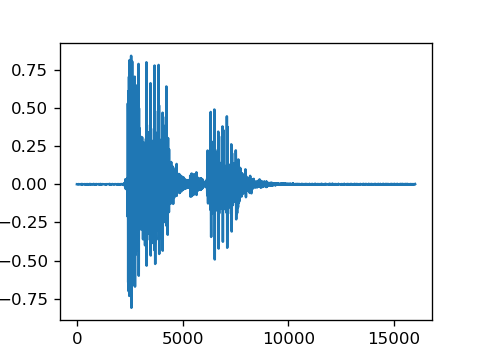

In [40]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy())
plt.show()

In [15]:
import IPython.display as ipd

In [16]:
ipd.Audio(waveform, rate=sample_rate)

In [17]:
for b in train_loader:
    print(b[0].size())
    break

/home/felix/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


torch.Size([32, 1, 16000])


In [18]:
res_fgn = test_fgn_layer.forward(b[0])

NameError: name 'test_fgn_layer' is not defined

In [19]:
res_fgn[0].size()

NameError: name 'res_fgn' is not defined

In [21]:
res_conv1d = test_conv1d_layer.forward(b[0])

In [22]:
res_conv1d[0].size()

torch.Size([2, 15998])

In [23]:
### working off a single 1D data
data_1d = torch.arange(0,10)
print(data_1d)
print(data_1d.size())

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
torch.Size([10])


In [49]:
centers = torch.arange(0,kernel_size*out_channels).reshape((out_channels,kernel_size))
print(centers)

tensor([[0, 1, 2],
        [3, 4, 5]])


In [25]:
# # from inputs to temp rectangle that looks like:
# 0 1 2 
# 1 2 3 
# 2 3 4 
# ...
# 7 8 9

In [26]:
# 1d data length
data_len = data_1d.size()[-1]
print(data_len)

10


In [44]:
kernel_size = 3
stride = 1
# for now only handle dilation 1
dilation = 1

In [34]:
# stride the data
data_1d_strided = torch.as_strided(input=data_1d, 
                                   size=(int(np.floor((data_len-(kernel_size-1)-1)/stride)+1),kernel_size),
                                   stride=(stride,1), storage_offset=0)
print(data_1d_strided)

tensor([[0, 1, 2, 3],
        [2, 3, 4, 5],
        [4, 5, 6, 7],
        [6, 7, 8, 9]])


In [29]:
# check that comparing with centers get broadcast correctly
data_1d_strided - centers

tensor([[[ 0,  0,  0],
         [ 1,  1,  1],
         [ 2,  2,  2],
         [ 3,  3,  3],
         [ 4,  4,  4],
         [ 5,  5,  5],
         [ 6,  6,  6],
         [ 7,  7,  7]],

        [[-3, -3, -3],
         [-2, -2, -2],
         [-1, -1, -1],
         [ 0,  0,  0],
         [ 1,  1,  1],
         [ 2,  2,  2],
         [ 3,  3,  3],
         [ 4,  4,  4]]])

In [30]:
# now dev for batches
data_batch = torch.arange(0,30)

In [38]:
data_batch = data_batch.reshape((3,1,10))

In [39]:
data_batch

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9]],

        [[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]],

        [[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]])

In [47]:
batch_size = 3
input_length = 10

In [46]:
data_batch_strided = torch.as_strided(input=data_batch, 
                                   size=(batch_size, 
                                         int(np.floor((data_len-(kernel_size-1)-1)/stride)+1),
                                         kernel_size),
                                   stride=(input_length,stride,1), storage_offset=0)
print(data_batch_strided)

tensor([[[ 0,  1,  2],
         [ 1,  2,  3],
         [ 2,  3,  4],
         [ 3,  4,  5],
         [ 4,  5,  6],
         [ 5,  6,  7],
         [ 6,  7,  8],
         [ 7,  8,  9]],

        [[10, 11, 12],
         [11, 12, 13],
         [12, 13, 14],
         [13, 14, 15],
         [14, 15, 16],
         [15, 16, 17],
         [16, 17, 18],
         [17, 18, 19]],

        [[20, 21, 22],
         [21, 22, 23],
         [22, 23, 24],
         [23, 24, 25],
         [24, 25, 26],
         [25, 26, 27],
         [26, 27, 28],
         [27, 28, 29]]])


In [59]:
output = data_batch_strided.unsqueeze(2) - centers.unsqueeze(0).unsqueeze(0)
print(output)

tensor([[[[ 0,  0,  0],
          [-3, -3, -3]],

         [[ 1,  1,  1],
          [-2, -2, -2]],

         [[ 2,  2,  2],
          [-1, -1, -1]],

         [[ 3,  3,  3],
          [ 0,  0,  0]],

         [[ 4,  4,  4],
          [ 1,  1,  1]],

         [[ 5,  5,  5],
          [ 2,  2,  2]],

         [[ 6,  6,  6],
          [ 3,  3,  3]],

         [[ 7,  7,  7],
          [ 4,  4,  4]]],


        [[[10, 10, 10],
          [ 7,  7,  7]],

         [[11, 11, 11],
          [ 8,  8,  8]],

         [[12, 12, 12],
          [ 9,  9,  9]],

         [[13, 13, 13],
          [10, 10, 10]],

         [[14, 14, 14],
          [11, 11, 11]],

         [[15, 15, 15],
          [12, 12, 12]],

         [[16, 16, 16],
          [13, 13, 13]],

         [[17, 17, 17],
          [14, 14, 14]]],


        [[[20, 20, 20],
          [17, 17, 17]],

         [[21, 21, 21],
          [18, 18, 18]],

         [[22, 22, 22],
          [19, 19, 19]],

         [[23, 23, 23],
          [20, 20, 20]

In [61]:
output.size()

torch.Size([3, 8, 2, 3])

In [53]:
data_batch_strided.size()

torch.Size([3, 8, 3])

In [55]:
centers.size()

torch.Size([2, 3])

In [57]:
data_batch_strided.unsqueeze(2).size()

torch.Size([3, 8, 1, 3])